In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention
import sys,os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50.json')
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()

(Index(['Topic', 'Title', 'article Id', 'Headline'], dtype='object'),
 Index(['Unnamed: 0', 'Topic', 'Article', 'Claim'], dtype='object'),
 522,
 522,
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'sentences', 'type',
        'urls'],
       dtype='object'))

In [4]:
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)

In [5]:
0.8*475

380.0

In [6]:
titles = sorted(df_hd_tp_cdc.Title.unique())
non_test_titles = list(set(titles)-set(test_titles))
val_titles = non_test_titles[380:]
train_titles = titles[:380]
len(train_titles),len(val_titles),len(test_titles)

(380, 95, 47)

In [7]:
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 1000

In [8]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [9]:
def datagen_cdc(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        hd = dataframe[dataframe.Title==idx]['Headline'].values[0].lower()
        hds.append(hd)
        ar_id = dataframe[dataframe.Title==idx]['article Id'].values[0]
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = article_vectors[ar_id]
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes=[],[],[],[]
            counter=0
            
def datagen_dnf(batchsize,dataframe):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        idx=np.random.choice(dataframe.id.nunique())
        hd = dataframe[dataframe.id==idx]['headline'].values[0]
        ar_id = dataframe[dataframe.id==idx]['id'].values[0]
        cl = dataframe[dataframe.id==idx]['sentences'].values[0]
        hds.append(hd)
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
        with open('evaluation_set/deepnofakes/cleaned/article_{0}.txt'.format(ar_id)) as f:
            article = f.readlines()
            
        article=''.join(article)
        # print(article)
        article = article.replace('[REF]','')
        doc = sentencizer(article)
        sentences = [sent.string.strip() for sent in doc.sents]
    
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = []
        for s in sentences:
            vectors.append(nlp(s.lower()).vector)
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes=[],[],[],[]
            counter=0
            

In [10]:
tdg = datagen_cdc(train_batchsize,df_hd_tp_cdc,mode='train')
vdg = datagen_cdc(val_batchsize,df_hd_tp_cdc,mode='val')
test_dg = datagen_cdc(test_batchsize,df_hd_tp_cdc,mode='test')

In [11]:
x,y = next(test_dg)

In [12]:
x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

((50, 1300, 300), (50, 300), (50, 50, 20000))

model params: 6840472


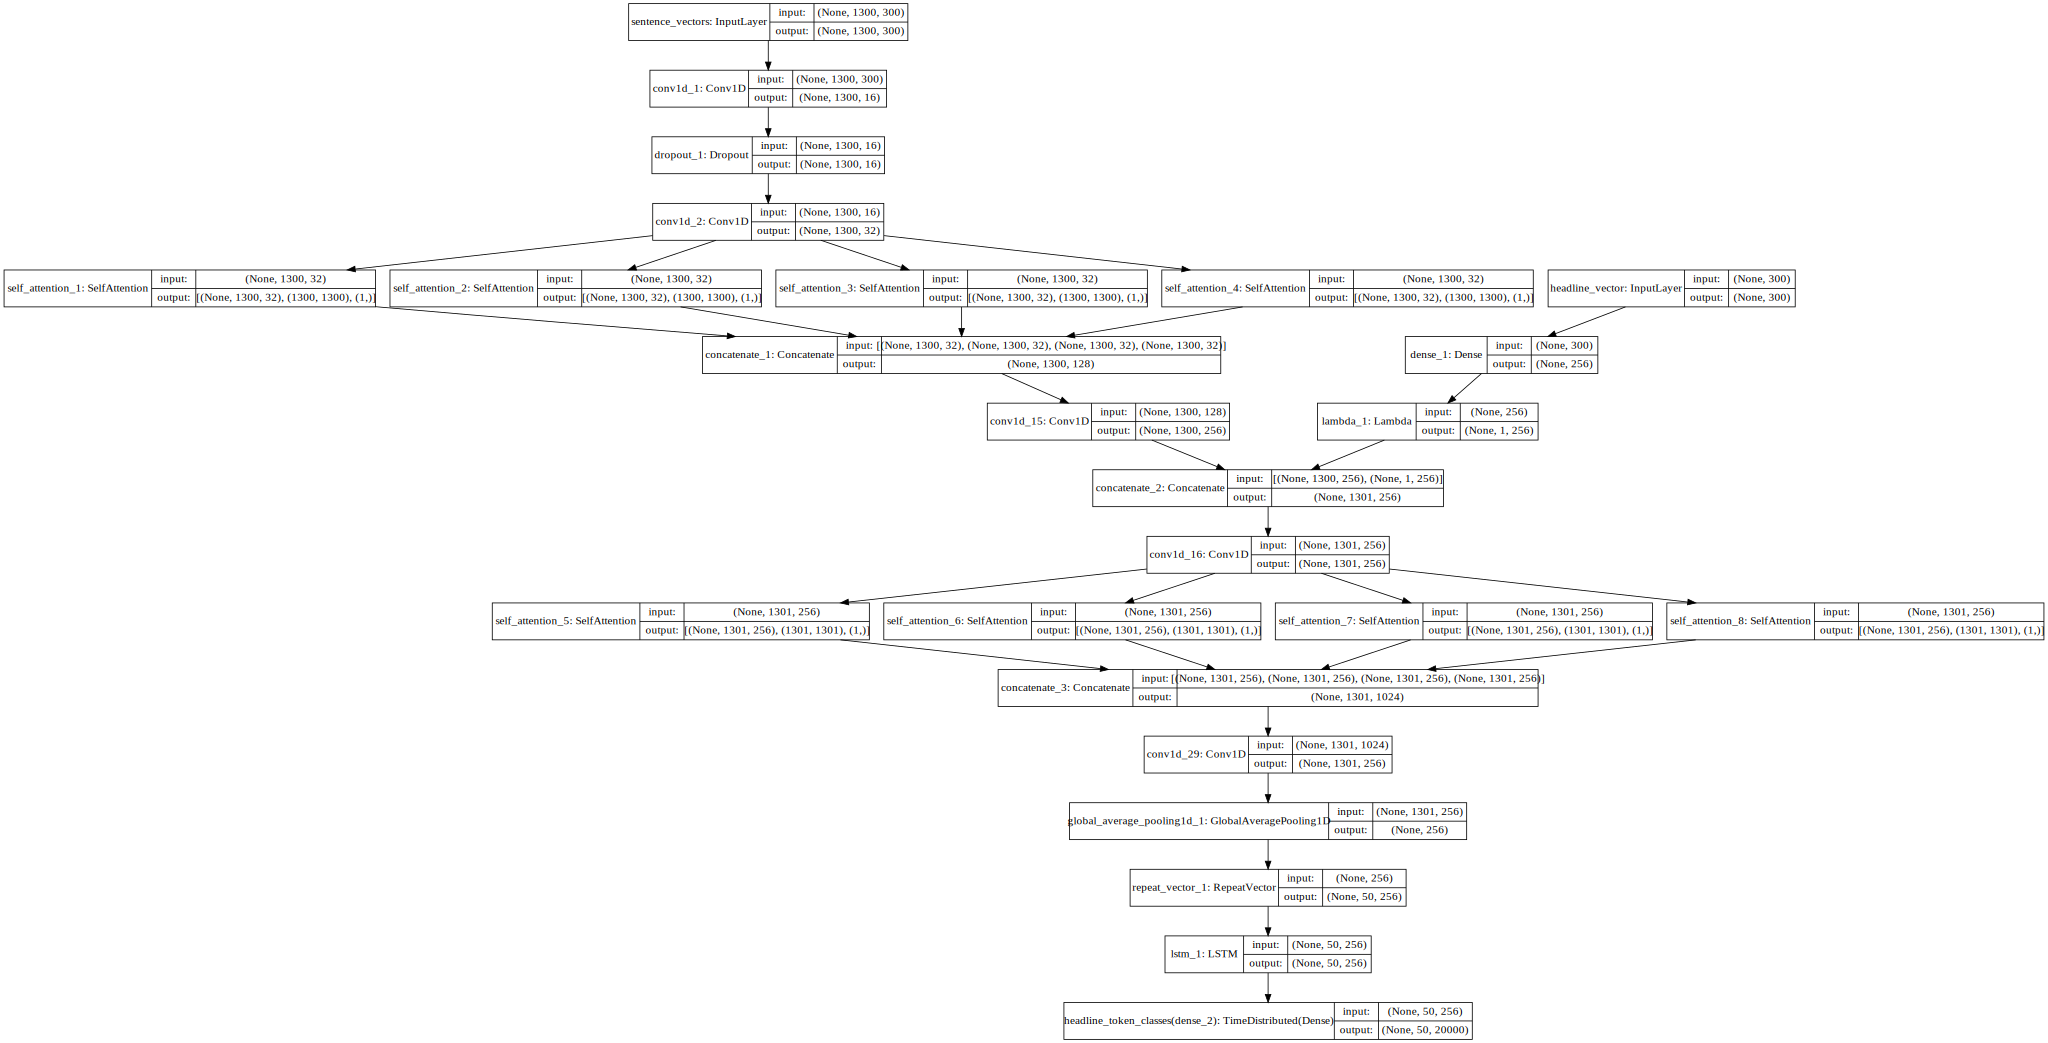

In [13]:
def build_model():
    inp_sentence_vectors = Input(shape=(1300, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]))(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline=Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    concat2 = Concatenate(axis=1)([conv3,headline])
    conv4 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat2)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = SelfAttention(int(conv4.shape[-1]))(conv4)
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = SelfAttention(int(conv4.shape[-1]))(conv4)
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = SelfAttention(int(conv4.shape[-1]))(conv4)
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = SelfAttention(int(conv4.shape[-1]))(conv4)  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    conv5 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat3)
    gap = GlobalAveragePooling1D()(conv5)
    repeat = RepeatVector(50)(gap)
    lstm = LSTM(256,return_sequences=True)(repeat)
    gen_hd_vector = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
# model.summary()
print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [14]:
dt = datetime.now()
mc = ModelCheckpoint('weights/cdc_sa_sent_hd_word.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/cdc_sa_sent_hd_word/{0}'.format(dt.timestamp()),write_graph=True)

In [ ]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=1000
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs+9000)

Epoch 1001/10000
4/4 [==============================] - 4s 958ms/step - loss: 1.1173 - acc: 0.8503 - val_loss: 1.2225 - val_acc: 0.8400
Epoch 1002/10000
4/4 [==============================] - 3s 804ms/step - loss: 1.1418 - acc: 0.8486 - val_loss: 1.2150 - val_acc: 0.8369
Epoch 1003/10000
4/4 [==============================] - 3s 786ms/step - loss: 1.2087 - acc: 0.8377 - val_loss: 1.0857 - val_acc: 0.8569
Epoch 1004/10000
4/4 [==============================] - 2s 583ms/step - loss: 1.2687 - acc: 0.8312 - val_loss: 1.3473 - val_acc: 0.8263
Epoch 1005/10000
4/4 [==============================] - 2s 513ms/step - loss: 1.0839 - acc: 0.8561 - val_loss: 1.2887 - val_acc: 0.8313
Epoch 1006/10000
4/4 [==============================] - 2s 518ms/step - loss: 1.1994 - acc: 0.8434 - val_loss: 1.2523 - val_acc: 0.8375
Epoch 1007/10000
4/4 [==============================] - 2s 516ms/step - loss: 1.2609 - acc: 0.8317 - val_loss: 1.0772 - val_acc: 0.8625
Epoch 1008/10000
4/4 [==========================

4/4 [==============================] - 2s 537ms/step - loss: 1.1301 - acc: 0.8497 - val_loss: 1.0350 - val_acc: 0.8606
Epoch 1062/10000
4/4 [==============================] - 2s 545ms/step - loss: 1.1491 - acc: 0.8483 - val_loss: 1.1836 - val_acc: 0.8450
Epoch 1063/10000
4/4 [==============================] - 2s 512ms/step - loss: 1.1678 - acc: 0.8439 - val_loss: 1.0377 - val_acc: 0.8662
Epoch 1064/10000
4/4 [==============================] - 2s 519ms/step - loss: 1.0736 - acc: 0.8564 - val_loss: 1.0997 - val_acc: 0.8562
Epoch 1065/10000
4/4 [==============================] - 2s 558ms/step - loss: 1.1088 - acc: 0.8513 - val_loss: 1.3517 - val_acc: 0.8288
Epoch 1066/10000
4/4 [==============================] - 2s 537ms/step - loss: 1.1779 - acc: 0.8430 - val_loss: 1.0728 - val_acc: 0.8556
Epoch 1067/10000
4/4 [==============================] - 2s 525ms/step - loss: 1.2147 - acc: 0.8402 - val_loss: 1.1694 - val_acc: 0.8469
Epoch 1068/10000
4/4 [==============================] - 2s 514ms/

4/4 [==============================] - 2s 515ms/step - loss: 1.1572 - acc: 0.8478 - val_loss: 1.0027 - val_acc: 0.8644
Epoch 1122/10000
4/4 [==============================] - 2s 527ms/step - loss: 1.1133 - acc: 0.8517 - val_loss: 1.1079 - val_acc: 0.8581
Epoch 1123/10000
4/4 [==============================] - 2s 550ms/step - loss: 1.2002 - acc: 0.8403 - val_loss: 1.3709 - val_acc: 0.8188
Epoch 1124/10000
4/4 [==============================] - 2s 548ms/step - loss: 1.1033 - acc: 0.8516 - val_loss: 1.0457 - val_acc: 0.8612
Epoch 1125/10000
4/4 [==============================] - 2s 522ms/step - loss: 1.0795 - acc: 0.8569 - val_loss: 1.0767 - val_acc: 0.8562
Epoch 1126/10000
4/4 [==============================] - 2s 523ms/step - loss: 1.1535 - acc: 0.8459 - val_loss: 1.2594 - val_acc: 0.8369
Epoch 1127/10000
4/4 [==============================] - 2s 535ms/step - loss: 1.1440 - acc: 0.8483 - val_loss: 1.1592 - val_acc: 0.8444
Epoch 1128/10000
4/4 [==============================] - 2s 555ms/

4/4 [==============================] - 2s 547ms/step - loss: 1.0792 - acc: 0.8569 - val_loss: 1.2887 - val_acc: 0.8325
Epoch 1182/10000
4/4 [==============================] - 2s 533ms/step - loss: 1.2743 - acc: 0.8319 - val_loss: 1.0863 - val_acc: 0.8506
Epoch 1183/10000
4/4 [==============================] - 2s 548ms/step - loss: 1.2255 - acc: 0.8370 - val_loss: 1.1008 - val_acc: 0.8625
Epoch 1184/10000
4/4 [==============================] - 2s 540ms/step - loss: 1.2599 - acc: 0.8322 - val_loss: 1.2088 - val_acc: 0.8356
Epoch 1185/10000
4/4 [==============================] - 2s 542ms/step - loss: 1.0989 - acc: 0.8534 - val_loss: 1.2099 - val_acc: 0.8375
Epoch 1186/10000
4/4 [==============================] - 2s 562ms/step - loss: 1.3233 - acc: 0.8231 - val_loss: 1.0614 - val_acc: 0.8625
Epoch 1187/10000
4/4 [==============================] - 2s 530ms/step - loss: 1.1138 - acc: 0.8519 - val_loss: 1.3054 - val_acc: 0.8300
Epoch 1188/10000
4/4 [==============================] - 2s 551ms/

4/4 [==============================] - 2s 521ms/step - loss: 1.1960 - acc: 0.8402 - val_loss: 1.1225 - val_acc: 0.8500
Epoch 1242/10000
4/4 [==============================] - 2s 541ms/step - loss: 1.0985 - acc: 0.8533 - val_loss: 1.1698 - val_acc: 0.8444
Epoch 1243/10000
4/4 [==============================] - 2s 536ms/step - loss: 1.2749 - acc: 0.8292 - val_loss: 1.0863 - val_acc: 0.8519
Epoch 1244/10000
4/4 [==============================] - 2s 521ms/step - loss: 1.1752 - acc: 0.8453 - val_loss: 1.2741 - val_acc: 0.8325
Epoch 1245/10000
4/4 [==============================] - 2s 547ms/step - loss: 1.1563 - acc: 0.8456 - val_loss: 1.1785 - val_acc: 0.8419
Epoch 1246/10000
4/4 [==============================] - 2s 533ms/step - loss: 1.1429 - acc: 0.8481 - val_loss: 1.3685 - val_acc: 0.8200
Epoch 1247/10000
4/4 [==============================] - 2s 550ms/step - loss: 1.1841 - acc: 0.8430 - val_loss: 1.1647 - val_acc: 0.8512
Epoch 1248/10000
4/4 [==============================] - 2s 530ms/

4/4 [==============================] - 2s 537ms/step - loss: 1.1386 - acc: 0.8516 - val_loss: 1.1557 - val_acc: 0.8481
Epoch 1302/10000
4/4 [==============================] - 2s 541ms/step - loss: 1.2438 - acc: 0.8356 - val_loss: 1.1248 - val_acc: 0.8550
Epoch 1303/10000
4/4 [==============================] - 2s 531ms/step - loss: 1.2285 - acc: 0.8361 - val_loss: 1.3689 - val_acc: 0.8169
Epoch 1304/10000
4/4 [==============================] - 2s 549ms/step - loss: 1.1362 - acc: 0.8477 - val_loss: 1.0408 - val_acc: 0.8656
Epoch 1305/10000
4/4 [==============================] - 2s 536ms/step - loss: 1.1185 - acc: 0.8511 - val_loss: 1.3194 - val_acc: 0.8306
Epoch 1306/10000
4/4 [==============================] - 2s 539ms/step - loss: 1.2582 - acc: 0.8306 - val_loss: 1.1070 - val_acc: 0.8550
Epoch 1307/10000
4/4 [==============================] - 2s 539ms/step - loss: 1.2240 - acc: 0.8362 - val_loss: 1.1689 - val_acc: 0.8406
Epoch 1308/10000
4/4 [==============================] - 2s 537ms/

4/4 [==============================] - 2s 526ms/step - loss: 1.1940 - acc: 0.8419 - val_loss: 1.2398 - val_acc: 0.8375
Epoch 1362/10000
4/4 [==============================] - 2s 551ms/step - loss: 1.1240 - acc: 0.8508 - val_loss: 1.3138 - val_acc: 0.8250
Epoch 1363/10000
4/4 [==============================] - 2s 559ms/step - loss: 1.1944 - acc: 0.8411 - val_loss: 1.1092 - val_acc: 0.8469
Epoch 1364/10000
4/4 [==============================] - 2s 539ms/step - loss: 1.1873 - acc: 0.8438 - val_loss: 1.2773 - val_acc: 0.8300
Epoch 1365/10000
4/4 [==============================] - 2s 561ms/step - loss: 1.2694 - acc: 0.8292 - val_loss: 1.2835 - val_acc: 0.8300
Epoch 1366/10000
4/4 [==============================] - 2s 542ms/step - loss: 1.2598 - acc: 0.8337 - val_loss: 1.2292 - val_acc: 0.8450
Epoch 1367/10000
4/4 [==============================] - 2s 546ms/step - loss: 1.2267 - acc: 0.8362 - val_loss: 1.2527 - val_acc: 0.8350
Epoch 1368/10000
4/4 [==============================] - 2s 535ms/

4/4 [==============================] - 2s 527ms/step - loss: 1.1367 - acc: 0.8486 - val_loss: 1.1678 - val_acc: 0.8519
Epoch 1422/10000
4/4 [==============================] - 2s 530ms/step - loss: 1.1728 - acc: 0.8406 - val_loss: 1.0812 - val_acc: 0.8581
Epoch 1423/10000
4/4 [==============================] - 2s 554ms/step - loss: 1.1874 - acc: 0.8433 - val_loss: 1.2967 - val_acc: 0.8288
Epoch 1424/10000
4/4 [==============================] - 2s 553ms/step - loss: 1.1141 - acc: 0.8502 - val_loss: 1.1488 - val_acc: 0.8500
Epoch 1425/10000
4/4 [==============================] - 2s 549ms/step - loss: 1.1817 - acc: 0.8422 - val_loss: 1.3339 - val_acc: 0.8256
Epoch 1426/10000
4/4 [==============================] - 2s 540ms/step - loss: 1.1082 - acc: 0.8537 - val_loss: 1.1740 - val_acc: 0.8475
Epoch 1427/10000
4/4 [==============================] - 2s 552ms/step - loss: 1.1477 - acc: 0.8469 - val_loss: 1.3586 - val_acc: 0.8188
Epoch 1428/10000
4/4 [==============================] - 2s 551ms/

4/4 [==============================] - 2s 541ms/step - loss: 1.1982 - acc: 0.8398 - val_loss: 1.0378 - val_acc: 0.8619
Epoch 1482/10000
4/4 [==============================] - 2s 540ms/step - loss: 1.1760 - acc: 0.8445 - val_loss: 1.2097 - val_acc: 0.8431
Epoch 1483/10000
4/4 [==============================] - 2s 550ms/step - loss: 1.0501 - acc: 0.8595 - val_loss: 1.0781 - val_acc: 0.8612
Epoch 1484/10000
4/4 [==============================] - 2s 560ms/step - loss: 1.1511 - acc: 0.8497 - val_loss: 1.4967 - val_acc: 0.8087
Epoch 1485/10000
4/4 [==============================] - 2s 557ms/step - loss: 1.2127 - acc: 0.8397 - val_loss: 1.1891 - val_acc: 0.8450
Epoch 1486/10000
4/4 [==============================] - 2s 528ms/step - loss: 1.1826 - acc: 0.8423 - val_loss: 1.3224 - val_acc: 0.8238
Epoch 1487/10000
4/4 [==============================] - 2s 548ms/step - loss: 1.1225 - acc: 0.8520 - val_loss: 1.1719 - val_acc: 0.8456
Epoch 1488/10000
4/4 [==============================] - 2s 578ms/

4/4 [==============================] - 2s 557ms/step - loss: 1.2000 - acc: 0.8397 - val_loss: 1.2139 - val_acc: 0.8413
Epoch 1542/10000
4/4 [==============================] - 2s 548ms/step - loss: 1.1755 - acc: 0.8416 - val_loss: 1.3044 - val_acc: 0.8325
Epoch 1543/10000
4/4 [==============================] - 2s 544ms/step - loss: 1.2273 - acc: 0.8367 - val_loss: 1.1442 - val_acc: 0.8481
Epoch 1544/10000
4/4 [==============================] - 2s 535ms/step - loss: 1.2081 - acc: 0.8403 - val_loss: 1.2019 - val_acc: 0.8363
Epoch 1545/10000
4/4 [==============================] - 2s 560ms/step - loss: 1.1367 - acc: 0.8492 - val_loss: 1.2595 - val_acc: 0.8363
Epoch 1546/10000
4/4 [==============================] - 2s 566ms/step - loss: 1.1882 - acc: 0.8394 - val_loss: 1.3725 - val_acc: 0.8206
Epoch 1547/10000
4/4 [==============================] - 2s 559ms/step - loss: 1.2869 - acc: 0.8286 - val_loss: 1.1929 - val_acc: 0.8394
Epoch 1548/10000
4/4 [==============================] - 2s 551ms/

4/4 [==============================] - 2s 571ms/step - loss: 1.1437 - acc: 0.8475 - val_loss: 1.2933 - val_acc: 0.8288
Epoch 1602/10000
4/4 [==============================] - 2s 588ms/step - loss: 1.2429 - acc: 0.8338 - val_loss: 1.2205 - val_acc: 0.8450
Epoch 1603/10000
4/4 [==============================] - 2s 574ms/step - loss: 1.1638 - acc: 0.8445 - val_loss: 1.0153 - val_acc: 0.8662
Epoch 1604/10000
4/4 [==============================] - 2s 563ms/step - loss: 1.2252 - acc: 0.8347 - val_loss: 1.1595 - val_acc: 0.8494
Epoch 1605/10000
4/4 [==============================] - 2s 547ms/step - loss: 1.1128 - acc: 0.8517 - val_loss: 1.1103 - val_acc: 0.8494
Epoch 1606/10000
4/4 [==============================] - 2s 570ms/step - loss: 1.1566 - acc: 0.8470 - val_loss: 1.1396 - val_acc: 0.8456
Epoch 1607/10000
4/4 [==============================] - 2s 573ms/step - loss: 1.2960 - acc: 0.8263 - val_loss: 1.4041 - val_acc: 0.8069
Epoch 1608/10000
4/4 [==============================] - 2s 566ms/

4/4 [==============================] - 2s 557ms/step - loss: 1.3138 - acc: 0.8261 - val_loss: 1.0756 - val_acc: 0.8569
Epoch 1662/10000
4/4 [==============================] - 2s 564ms/step - loss: 1.1887 - acc: 0.8402 - val_loss: 1.2658 - val_acc: 0.8306
Epoch 1663/10000
4/4 [==============================] - 2s 558ms/step - loss: 1.1881 - acc: 0.8388 - val_loss: 1.0547 - val_acc: 0.8587
Epoch 1664/10000
4/4 [==============================] - 2s 567ms/step - loss: 1.1534 - acc: 0.8455 - val_loss: 1.1349 - val_acc: 0.8475
Epoch 1665/10000
4/4 [==============================] - 2s 567ms/step - loss: 1.1360 - acc: 0.8475 - val_loss: 1.4399 - val_acc: 0.8163
Epoch 1666/10000
4/4 [==============================] - 2s 555ms/step - loss: 1.1457 - acc: 0.8483 - val_loss: 1.2869 - val_acc: 0.8263
Epoch 1667/10000
4/4 [==============================] - 2s 582ms/step - loss: 1.1120 - acc: 0.8494 - val_loss: 1.0445 - val_acc: 0.8594
Epoch 1668/10000
4/4 [==============================] - 2s 581ms/

4/4 [==============================] - 2s 561ms/step - loss: 1.1208 - acc: 0.8489 - val_loss: 1.2656 - val_acc: 0.8313
Epoch 1722/10000
4/4 [==============================] - 2s 563ms/step - loss: 1.1577 - acc: 0.8461 - val_loss: 1.0760 - val_acc: 0.8625
Epoch 1723/10000
4/4 [==============================] - 2s 565ms/step - loss: 1.0731 - acc: 0.8570 - val_loss: 1.2181 - val_acc: 0.8350
Epoch 1724/10000
4/4 [==============================] - 2s 556ms/step - loss: 1.1607 - acc: 0.8456 - val_loss: 1.1324 - val_acc: 0.8444
Epoch 1725/10000
4/4 [==============================] - 2s 574ms/step - loss: 1.2473 - acc: 0.8328 - val_loss: 1.1020 - val_acc: 0.8506
Epoch 1726/10000
4/4 [==============================] - 2s 579ms/step - loss: 1.1447 - acc: 0.8489 - val_loss: 1.2378 - val_acc: 0.8319
Epoch 1727/10000
4/4 [==============================] - 2s 578ms/step - loss: 1.1986 - acc: 0.8406 - val_loss: 1.0980 - val_acc: 0.8531
Epoch 1728/10000
4/4 [==============================] - 2s 554ms/

4/4 [==============================] - 2s 588ms/step - loss: 1.1740 - acc: 0.8434 - val_loss: 1.1158 - val_acc: 0.8525
Epoch 1782/10000
4/4 [==============================] - 2s 571ms/step - loss: 1.1776 - acc: 0.8428 - val_loss: 1.1461 - val_acc: 0.8475
Epoch 1783/10000
4/4 [==============================] - 2s 579ms/step - loss: 1.1621 - acc: 0.8434 - val_loss: 1.2670 - val_acc: 0.8350
Epoch 1784/10000
4/4 [==============================] - 2s 569ms/step - loss: 1.1755 - acc: 0.8417 - val_loss: 1.2440 - val_acc: 0.8325
Epoch 1785/10000
4/4 [==============================] - 2s 570ms/step - loss: 1.1882 - acc: 0.8422 - val_loss: 1.0795 - val_acc: 0.8519
Epoch 1786/10000
4/4 [==============================] - 2s 587ms/step - loss: 1.1266 - acc: 0.8497 - val_loss: 1.3326 - val_acc: 0.8181
Epoch 1787/10000
4/4 [==============================] - 2s 557ms/step - loss: 1.1202 - acc: 0.8509 - val_loss: 1.3557 - val_acc: 0.8244
Epoch 1788/10000
4/4 [==============================] - 2s 564ms/

4/4 [==============================] - 2s 567ms/step - loss: 1.1558 - acc: 0.8447 - val_loss: 1.2010 - val_acc: 0.8444
Epoch 1842/10000
4/4 [==============================] - 2s 554ms/step - loss: 1.2361 - acc: 0.8328 - val_loss: 1.1507 - val_acc: 0.8481
Epoch 1843/10000
4/4 [==============================] - 2s 579ms/step - loss: 1.1594 - acc: 0.8461 - val_loss: 1.0968 - val_acc: 0.8556
Epoch 1844/10000
4/4 [==============================] - 2s 590ms/step - loss: 1.1793 - acc: 0.8400 - val_loss: 1.2861 - val_acc: 0.8269
Epoch 1845/10000
4/4 [==============================] - 2s 592ms/step - loss: 1.0974 - acc: 0.8527 - val_loss: 1.1333 - val_acc: 0.8475
Epoch 1846/10000
4/4 [==============================] - 2s 570ms/step - loss: 1.2026 - acc: 0.8380 - val_loss: 1.2008 - val_acc: 0.8444
Epoch 1847/10000
4/4 [==============================] - 2s 579ms/step - loss: 1.1459 - acc: 0.8473 - val_loss: 1.0076 - val_acc: 0.8644
Epoch 1848/10000
4/4 [==============================] - 2s 555ms/

4/4 [==============================] - 2s 576ms/step - loss: 1.1549 - acc: 0.8456 - val_loss: 1.1734 - val_acc: 0.8444
Epoch 1902/10000
4/4 [==============================] - 2s 579ms/step - loss: 1.1222 - acc: 0.8506 - val_loss: 1.1487 - val_acc: 0.8469
Epoch 1903/10000
4/4 [==============================] - 2s 571ms/step - loss: 1.1636 - acc: 0.8458 - val_loss: 1.0313 - val_acc: 0.8581
Epoch 1904/10000
4/4 [==============================] - 2s 577ms/step - loss: 1.0363 - acc: 0.8611 - val_loss: 1.1478 - val_acc: 0.8469
Epoch 1905/10000
4/4 [==============================] - 2s 568ms/step - loss: 1.2063 - acc: 0.8375 - val_loss: 1.0308 - val_acc: 0.8619
Epoch 1906/10000
4/4 [==============================] - 2s 574ms/step - loss: 1.1149 - acc: 0.8506 - val_loss: 1.2117 - val_acc: 0.8406
Epoch 1907/10000
4/4 [==============================] - 2s 591ms/step - loss: 1.2615 - acc: 0.8305 - val_loss: 1.2563 - val_acc: 0.8325
Epoch 1908/10000
4/4 [==============================] - 2s 577ms/

4/4 [==============================] - 2s 589ms/step - loss: 1.1193 - acc: 0.8516 - val_loss: 1.2869 - val_acc: 0.8300
Epoch 1962/10000
4/4 [==============================] - 2s 593ms/step - loss: 1.1981 - acc: 0.8389 - val_loss: 1.2278 - val_acc: 0.8325
Epoch 1963/10000
4/4 [==============================] - 2s 567ms/step - loss: 1.1583 - acc: 0.8444 - val_loss: 1.1876 - val_acc: 0.8419
Epoch 1964/10000
4/4 [==============================] - 2s 582ms/step - loss: 1.1882 - acc: 0.8419 - val_loss: 1.1886 - val_acc: 0.8425
Epoch 1965/10000
4/4 [==============================] - 2s 590ms/step - loss: 1.2200 - acc: 0.8378 - val_loss: 1.0443 - val_acc: 0.8594
Epoch 1966/10000
4/4 [==============================] - 2s 607ms/step - loss: 1.1433 - acc: 0.8481 - val_loss: 1.2354 - val_acc: 0.8356
Epoch 1967/10000
4/4 [==============================] - 2s 558ms/step - loss: 1.2109 - acc: 0.8386 - val_loss: 1.0007 - val_acc: 0.8681
Epoch 1968/10000
4/4 [==============================] - 2s 587ms/

4/4 [==============================] - 2s 583ms/step - loss: 1.0907 - acc: 0.8563 - val_loss: 1.2783 - val_acc: 0.8331
Epoch 2022/10000
4/4 [==============================] - 2s 564ms/step - loss: 1.1457 - acc: 0.8458 - val_loss: 1.1479 - val_acc: 0.8500
Epoch 2023/10000
4/4 [==============================] - 2s 579ms/step - loss: 1.1128 - acc: 0.8520 - val_loss: 1.1730 - val_acc: 0.8400
Epoch 2024/10000
4/4 [==============================] - 2s 589ms/step - loss: 1.1765 - acc: 0.8403 - val_loss: 1.1060 - val_acc: 0.8550
Epoch 2025/10000
4/4 [==============================] - 2s 580ms/step - loss: 1.1441 - acc: 0.8469 - val_loss: 1.1959 - val_acc: 0.8381
Epoch 2026/10000
4/4 [==============================] - 2s 576ms/step - loss: 1.1048 - acc: 0.8545 - val_loss: 1.0480 - val_acc: 0.8631
Epoch 2027/10000
4/4 [==============================] - 2s 590ms/step - loss: 1.1738 - acc: 0.8427 - val_loss: 1.0383 - val_acc: 0.8662
Epoch 2028/10000
4/4 [==============================] - 2s 598ms/

4/4 [==============================] - 2s 595ms/step - loss: 1.1036 - acc: 0.8502 - val_loss: 1.0132 - val_acc: 0.8656
Epoch 2082/10000
4/4 [==============================] - 2s 596ms/step - loss: 1.3413 - acc: 0.8197 - val_loss: 1.1278 - val_acc: 0.8487
Epoch 2083/10000
4/4 [==============================] - 2s 592ms/step - loss: 1.2224 - acc: 0.8353 - val_loss: 1.2551 - val_acc: 0.8331
Epoch 2084/10000
4/4 [==============================] - 2s 606ms/step - loss: 1.1555 - acc: 0.8450 - val_loss: 0.9915 - val_acc: 0.8662
Epoch 2085/10000
4/4 [==============================] - 2s 600ms/step - loss: 1.1914 - acc: 0.8395 - val_loss: 1.2079 - val_acc: 0.8356
Epoch 2086/10000
4/4 [==============================] - 2s 598ms/step - loss: 1.0935 - acc: 0.8542 - val_loss: 0.9668 - val_acc: 0.8694
Epoch 2087/10000
4/4 [==============================] - 2s 567ms/step - loss: 1.1893 - acc: 0.8405 - val_loss: 1.3668 - val_acc: 0.8313
Epoch 2088/10000
4/4 [==============================] - 2s 564ms/

4/4 [==============================] - 2s 586ms/step - loss: 1.1081 - acc: 0.8528 - val_loss: 1.1005 - val_acc: 0.8544
Epoch 2142/10000
4/4 [==============================] - 2s 580ms/step - loss: 1.0795 - acc: 0.8541 - val_loss: 1.1413 - val_acc: 0.8519
Epoch 2143/10000
4/4 [==============================] - 2s 596ms/step - loss: 1.1323 - acc: 0.8481 - val_loss: 1.2350 - val_acc: 0.8369
Epoch 2144/10000
4/4 [==============================] - 2s 591ms/step - loss: 1.2205 - acc: 0.8369 - val_loss: 1.3448 - val_acc: 0.8238
Epoch 2145/10000
4/4 [==============================] - 2s 573ms/step - loss: 1.1097 - acc: 0.8513 - val_loss: 1.1933 - val_acc: 0.8394
Epoch 2146/10000
4/4 [==============================] - 2s 611ms/step - loss: 1.2056 - acc: 0.8370 - val_loss: 1.1956 - val_acc: 0.8406
Epoch 2147/10000
4/4 [==============================] - 2s 586ms/step - loss: 1.2375 - acc: 0.8316 - val_loss: 1.3323 - val_acc: 0.8275
Epoch 2148/10000
4/4 [==============================] - 2s 614ms/

4/4 [==============================] - 2s 590ms/step - loss: 1.1263 - acc: 0.8491 - val_loss: 1.4068 - val_acc: 0.8175
Epoch 2202/10000
4/4 [==============================] - 2s 612ms/step - loss: 1.1087 - acc: 0.8519 - val_loss: 1.0704 - val_acc: 0.8556
Epoch 2203/10000
4/4 [==============================] - 2s 594ms/step - loss: 1.1032 - acc: 0.8511 - val_loss: 1.2973 - val_acc: 0.8294
Epoch 2204/10000
4/4 [==============================] - 2s 570ms/step - loss: 1.2163 - acc: 0.8378 - val_loss: 1.4504 - val_acc: 0.8144
Epoch 2205/10000
4/4 [==============================] - 2s 610ms/step - loss: 1.1984 - acc: 0.8403 - val_loss: 1.2348 - val_acc: 0.8363
Epoch 2206/10000
4/4 [==============================] - 2s 586ms/step - loss: 1.1640 - acc: 0.8422 - val_loss: 1.1648 - val_acc: 0.8462
Epoch 2207/10000
4/4 [==============================] - 2s 578ms/step - loss: 1.0676 - acc: 0.8578 - val_loss: 1.0569 - val_acc: 0.8575
Epoch 2208/10000
4/4 [==============================] - 2s 610ms/

4/4 [==============================] - 2s 606ms/step - loss: 1.1772 - acc: 0.8439 - val_loss: 0.9276 - val_acc: 0.8775
Epoch 2262/10000
4/4 [==============================] - 2s 615ms/step - loss: 1.1156 - acc: 0.8509 - val_loss: 1.0518 - val_acc: 0.8606
Epoch 2263/10000
4/4 [==============================] - 2s 605ms/step - loss: 1.1911 - acc: 0.8400 - val_loss: 1.3156 - val_acc: 0.8300
Epoch 2264/10000
4/4 [==============================] - 2s 625ms/step - loss: 1.1438 - acc: 0.8439 - val_loss: 1.1399 - val_acc: 0.8481
Epoch 2265/10000
4/4 [==============================] - 2s 597ms/step - loss: 1.1968 - acc: 0.8381 - val_loss: 1.2068 - val_acc: 0.8400
Epoch 2266/10000
4/4 [==============================] - 2s 615ms/step - loss: 1.2421 - acc: 0.8339 - val_loss: 1.1994 - val_acc: 0.8375
Epoch 2267/10000
4/4 [==============================] - 2s 603ms/step - loss: 1.1769 - acc: 0.8419 - val_loss: 1.0505 - val_acc: 0.8656
Epoch 2268/10000
4/4 [==============================] - 2s 608ms/

4/4 [==============================] - 2s 612ms/step - loss: 1.1436 - acc: 0.8456 - val_loss: 1.1860 - val_acc: 0.8506
Epoch 2322/10000
4/4 [==============================] - 2s 581ms/step - loss: 1.1383 - acc: 0.8462 - val_loss: 1.0353 - val_acc: 0.8594
Epoch 2323/10000
4/4 [==============================] - 2s 594ms/step - loss: 1.1682 - acc: 0.8430 - val_loss: 1.0940 - val_acc: 0.8556
Epoch 2324/10000
4/4 [==============================] - 2s 610ms/step - loss: 1.1699 - acc: 0.8416 - val_loss: 1.1056 - val_acc: 0.8531
Epoch 2325/10000
4/4 [==============================] - 2s 614ms/step - loss: 1.1787 - acc: 0.8434 - val_loss: 1.1935 - val_acc: 0.8406
Epoch 2326/10000
4/4 [==============================] - 2s 609ms/step - loss: 1.1168 - acc: 0.8486 - val_loss: 1.0593 - val_acc: 0.8569
Epoch 2327/10000
4/4 [==============================] - 2s 598ms/step - loss: 1.2268 - acc: 0.8333 - val_loss: 1.1795 - val_acc: 0.8431
Epoch 2328/10000
4/4 [==============================] - 2s 603ms/

4/4 [==============================] - 3s 627ms/step - loss: 1.1865 - acc: 0.8405 - val_loss: 1.1474 - val_acc: 0.8512
Epoch 2382/10000
4/4 [==============================] - 2s 608ms/step - loss: 1.1133 - acc: 0.8520 - val_loss: 1.0288 - val_acc: 0.8644
Epoch 2383/10000
4/4 [==============================] - 2s 597ms/step - loss: 1.1764 - acc: 0.8411 - val_loss: 1.2076 - val_acc: 0.8413
Epoch 2384/10000
4/4 [==============================] - 2s 621ms/step - loss: 1.1347 - acc: 0.8480 - val_loss: 1.2729 - val_acc: 0.8350
Epoch 2385/10000
4/4 [==============================] - 2s 591ms/step - loss: 1.1551 - acc: 0.8456 - val_loss: 1.1609 - val_acc: 0.8519
Epoch 2386/10000
4/4 [==============================] - 2s 591ms/step - loss: 1.1630 - acc: 0.8441 - val_loss: 1.2192 - val_acc: 0.8431
Epoch 2387/10000
4/4 [==============================] - 2s 618ms/step - loss: 1.1541 - acc: 0.8439 - val_loss: 1.2790 - val_acc: 0.8275
Epoch 2388/10000
4/4 [==============================] - 2s 607ms/

4/4 [==============================] - 2s 615ms/step - loss: 1.1277 - acc: 0.8484 - val_loss: 1.2841 - val_acc: 0.8325
Epoch 2442/10000
4/4 [==============================] - 2s 607ms/step - loss: 1.1295 - acc: 0.8495 - val_loss: 1.1614 - val_acc: 0.8506
Epoch 2443/10000
4/4 [==============================] - 2s 623ms/step - loss: 1.0764 - acc: 0.8555 - val_loss: 1.0661 - val_acc: 0.8619
Epoch 2444/10000
4/4 [==============================] - 2s 591ms/step - loss: 1.1514 - acc: 0.8447 - val_loss: 1.1911 - val_acc: 0.8375
Epoch 2445/10000
4/4 [==============================] - 2s 612ms/step - loss: 1.2371 - acc: 0.8358 - val_loss: 1.1005 - val_acc: 0.8600
Epoch 2446/10000
4/4 [==============================] - 2s 609ms/step - loss: 1.1886 - acc: 0.8389 - val_loss: 1.2242 - val_acc: 0.8406
Epoch 2447/10000
4/4 [==============================] - 2s 617ms/step - loss: 1.1561 - acc: 0.8438 - val_loss: 1.2019 - val_acc: 0.8338
Epoch 2448/10000
4/4 [==============================] - 2s 623ms/

4/4 [==============================] - 2s 604ms/step - loss: 1.1276 - acc: 0.8478 - val_loss: 1.2450 - val_acc: 0.8344
Epoch 2502/10000
4/4 [==============================] - 3s 629ms/step - loss: 1.1927 - acc: 0.8397 - val_loss: 1.1047 - val_acc: 0.8512
Epoch 2503/10000
4/4 [==============================] - 2s 597ms/step - loss: 1.0854 - acc: 0.8538 - val_loss: 1.4373 - val_acc: 0.8169
Epoch 2504/10000
4/4 [==============================] - 2s 596ms/step - loss: 1.2653 - acc: 0.8311 - val_loss: 1.1130 - val_acc: 0.8531
Epoch 2505/10000
4/4 [==============================] - 2s 613ms/step - loss: 1.1575 - acc: 0.8461 - val_loss: 1.0933 - val_acc: 0.8556
Epoch 2506/10000
4/4 [==============================] - 3s 642ms/step - loss: 1.1759 - acc: 0.8394 - val_loss: 1.2034 - val_acc: 0.8506
Epoch 2507/10000
4/4 [==============================] - 2s 616ms/step - loss: 1.1735 - acc: 0.8408 - val_loss: 1.0770 - val_acc: 0.8537
Epoch 2508/10000
4/4 [==============================] - 2s 603ms/

4/4 [==============================] - 2s 614ms/step - loss: 1.0966 - acc: 0.8541 - val_loss: 1.1342 - val_acc: 0.8556
Epoch 2562/10000
4/4 [==============================] - 3s 642ms/step - loss: 1.2185 - acc: 0.8373 - val_loss: 1.2360 - val_acc: 0.8344
Epoch 2563/10000
4/4 [==============================] - 2s 619ms/step - loss: 1.2083 - acc: 0.8367 - val_loss: 1.2211 - val_acc: 0.8363
Epoch 2564/10000
4/4 [==============================] - 2s 620ms/step - loss: 1.2005 - acc: 0.8403 - val_loss: 1.1169 - val_acc: 0.8544
Epoch 2565/10000
4/4 [==============================] - 2s 612ms/step - loss: 1.1546 - acc: 0.8467 - val_loss: 1.1428 - val_acc: 0.8550
Epoch 2566/10000
4/4 [==============================] - 2s 604ms/step - loss: 1.0991 - acc: 0.8542 - val_loss: 1.1956 - val_acc: 0.8438
Epoch 2567/10000
4/4 [==============================] - 2s 606ms/step - loss: 1.1362 - acc: 0.8455 - val_loss: 0.9914 - val_acc: 0.8675
Epoch 2568/10000
4/4 [==============================] - 2s 595ms/

In [16]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [17]:
# df_res = pd.DataFrame(hist.history)

In [18]:
# df_res[['loss','val_loss']].plot()

In [19]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [20]:
model.load_weights('weights/cdc_sa_sent_hd_word.hdf5')
model.evaluate_generator(test_dg,steps=1)

[1.0414842367172241, 0.8623999953269958]

In [21]:
x,y = next(test_dg)
pred = model.predict(x)

In [22]:
x

{'article_id': array([2427,  203, 2221, 2245, 2202,   82, 2145, 2221, 2481, 2213, 2435,
        2198, 2198,  250, 2427,   61, 1352, 2385, 2555, 2608, 2427,  507,
        2429,  203,   21, 2429, 2607, 2221, 1352,  507, 2202,  235, 2213,
          61,  101, 2384, 2037,   21, 2145, 2397, 2608, 2213,  507,  203,
        1352, 2228,  101, 2224, 2429, 2429]),
 'headline': array(['multiculturalism would be embraced',
        'people should believe in affirmative action',
        'right to bear arms should be limited',
        'year round schooling should be introduced',
        'right to bear arms should be limited',
        'multiculturalism would be embraced', 'gambling sohuld be banned',
        'gambling sohuld be banned',
        'people should believe in affirmative action',
        'endangered species should be protected',
        'poor communities should be subsidized',
        'us is justified in using force to prevent states from acquiring nuclear weapons',
        'people should be

In [23]:
pred_classes = np.argmax(pred[0], axis=-1)

In [24]:
pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [25]:
doc = nlp(str(x['headline'][0]))
doc.text

'multiculturalism would be embraced'

In [26]:
ids = []
for token in doc:
    if token.has_vector:
#         print(token.norm)
        id = nlp.vocab.vectors.key2row[token.norm]
    else:
        id = None
    ids.append(id)

print([token for token in doc])
print(ids)

[multiculturalism, would, be, embraced]
[13773, 43, 22, 18228]


In [27]:
words = []
for idx in pred_classes:
    if idx!=0:
        words.append(id_word_mapping[idx])
print(words)

[]


In [28]:
# df_key_value = pd.DataFrame(nlp.vocab.vectors.key2row,index=[0]).T.reset_index()
# df_key_value.columns = ['key','value']

In [29]:
# df_key_value[df_key_value['value']==1282]['key'].values[0]

In [30]:
# nlp.vocab.vectors.data[1282]

In [31]:
# len(np.unique(list(nlp.vocab.vectors.key2row.keys()))),len(np.unique(list(nlp.vocab.vectors.key2row.values())))

In [32]:
# vocab_dict = {}

In [33]:
# counter = 0
# for s in nlp.vocab.strings:
#     print(s.
#     counter+=1
#     if counter==100:
#         break
    

In [34]:


#     else:
#         print(len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values))

In [35]:
# df_ar_cl_cdc.head()

In [36]:
# sorted(df_hd_tp_cdc.Title.unique())

In [37]:
# sorted(df_ar_cl_cdc.Article.unique())

In [38]:
# for token1,token2 in zip(nlp('how are you hillary!'),nlp('How are You HILLARY!')):
#     print(token1.rank,token2.rank)

In [39]:

from keras import backend as K
from keras.layers import Layer,InputSpec,Conv1D 

import tensorflow as tf

class SelfAttention(Layer):
    def __init__(self, ch, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_q_k = self.channels // 8
        self.filters_v = self.channels
#         print(self.channels,self.filters_f_g,self.filters_h)

    def build(self, input_shape):
        self.N = input_shape[1]        
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)

        super(SelfAttention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=3,
                                    axes={2: input_shape[-1]})
        self.built = True


    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        q = Conv1D(filters=self.filters_q_k, kernel_size=3, padding='same')(x)
        k = Conv1D(filters=self.filters_q_k, kernel_size=3, padding='same')(x)
        v = Conv1D(filters=self.filters_v, kernel_size=3, padding='same')(x)
#         print('q.shape,k.shape,v.shape,',q.shape,k.shape,v.shape)
        s = tf.matmul(q, k, transpose_b=True)  # # [bs, N, N]
#         print('s.shape:',s.shape)
        beta = K.softmax(s, axis=-1)  # attention map
        self.beta_shape = tuple(beta.shape[1:].as_list())
#         print('beta.shape:',beta.shape.as_list())
        o = K.batch_dot(beta, v)  # [bs, N, C]
#         print('o.shape:',o.shape)
#         o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x
#         print('x.shape:',x.shape)
        return [x, beta, self.gamma]

    def compute_output_shape(self, input_shape):
        return [input_shape,self.beta_shape, tuple(self.gamma.shape.as_list())]

In [40]:
 (1, 1) + (32, 32//8)

(1, 1, 32, 4)

In [41]:
q = Conv1D(filters=10, kernel_size=3, padding='same')

In [42]:
t = q(Input(shape=(32,3))).shape

In [43]:
tuple(t.as_list())

(None, 32, 10)